In [1]:
#import all the required python packages
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.ndimage.measurements import label
import collections

In [2]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [3]:
# Read in car and non-car images
cars = []
notcars = []

notcars = glob.glob('./data/non-vehicles/Extras/*.PNG') + glob.glob('./data/non-vehicles/GTI/*.PNG') \
            + glob.glob("./data/non-vehicles/Project_Video/*.jpg") 

cars = glob.glob('./data/vehicles/GTI_Far/*.PNG') + glob.glob('./data/vehicles/GTI_Left/*.PNG')+ \
        glob.glob('./data/vehicles/GTI_MiddleClose/*.PNG')+ glob.glob('./data/vehicles/GTI_Right/*.PNG') + \
         glob.glob('./data/vehicles/KITTI_extracted/*.PNG')+ glob.glob("./data/vehicles/Project_Video/*.jpg") 
            
print(len(notcars))
print(len(cars))

9050
8871


In [4]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 16  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 8 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features,car_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))
               , np.ones(len(car_features))))

C:\Conda\envs\my_conda\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [5]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
parameters = {'C':[1, 10]}
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
clf = GridSearchCV(svc, parameters)
# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# View the accuracy score
print('Best score for data1:', clf.best_score_) 
# View the best parameters for the model found using grid search
print('Best C:',clf.best_estimator_.C) 
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 16 orientations 8 pixels per cell and 8 cells per block
Feature vector length: 6240
98.94 Seconds to train SVC...
Best score for data1: 0.994961041385
Best C: 10
Test Accuracy of SVC =  0.9957


In [6]:
svc = LinearSVC(C = clf.best_estimator_.C)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

7.53 Seconds to train SVC...
Test Accuracy of SVC =  0.9957


In [7]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = svc.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[200, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [8]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    for box in bbox_list:
        if(np.max(heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]])>1):
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] +=2
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

C:\Conda\envs\my_conda\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


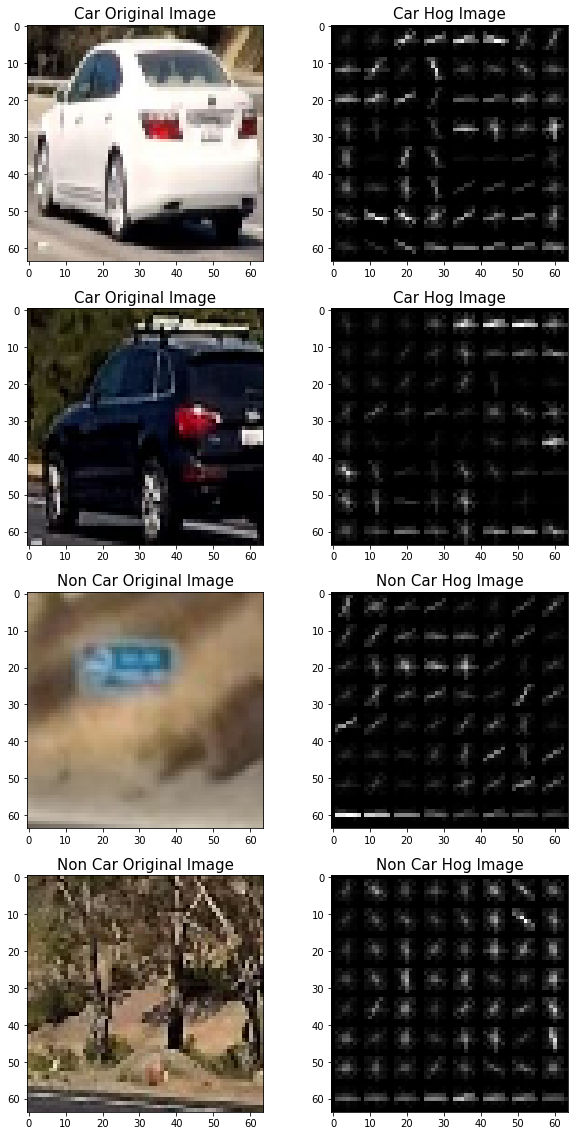

In [9]:
%matplotlib inline

image = mpimg.imread("./data/vehicles/Project_Video/image0.jpg")
feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
hog_features, hog_image = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
cnt =0
f, ax = plt.subplots(4, 2,figsize=(10,20))
ax[cnt,0].imshow(image)
ax[cnt,0].set_title('Car Original Image', fontsize=15)
ax[cnt,1].imshow(hog_image,"gray")
ax[cnt,1].set_title('Car Hog Image', fontsize=15)


image = mpimg.imread("./data/vehicles/Project_Video/image1.jpg")
feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
hog_features, hog_image = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
cnt+=1
ax[cnt,0].imshow(image)
ax[cnt,0].set_title('Car Original Image', fontsize=15)
ax[cnt,1].imshow(hog_image,"gray")
ax[cnt,1].set_title('Car Hog Image', fontsize=15)

image = mpimg.imread("./data/non-vehicles/Project_Video/extra3.jpg")
feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
hog_features, hog_image = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
cnt+=1
ax[cnt,0].imshow(image)
ax[cnt,0].set_title('Non Car Original Image', fontsize=15)
ax[cnt,1].imshow(hog_image,"gray")
ax[cnt,1].set_title('Non Car Hog Image', fontsize=15)

image = mpimg.imread("./data/non-vehicles/Project_Video/extra17_mod.jpg")
feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
hog_features, hog_image = get_hog_features(feature_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
cnt+=1
ax[cnt,0].imshow(image)
ax[cnt,0].set_title('Non Car Original Image', fontsize=15)
ax[cnt,1].imshow(hog_image,"gray")
ax[cnt,1].set_title('Non Car Hog Image', fontsize=15)
# Save the full figure...
f.savefig("./output_images/hog_images.jpg")

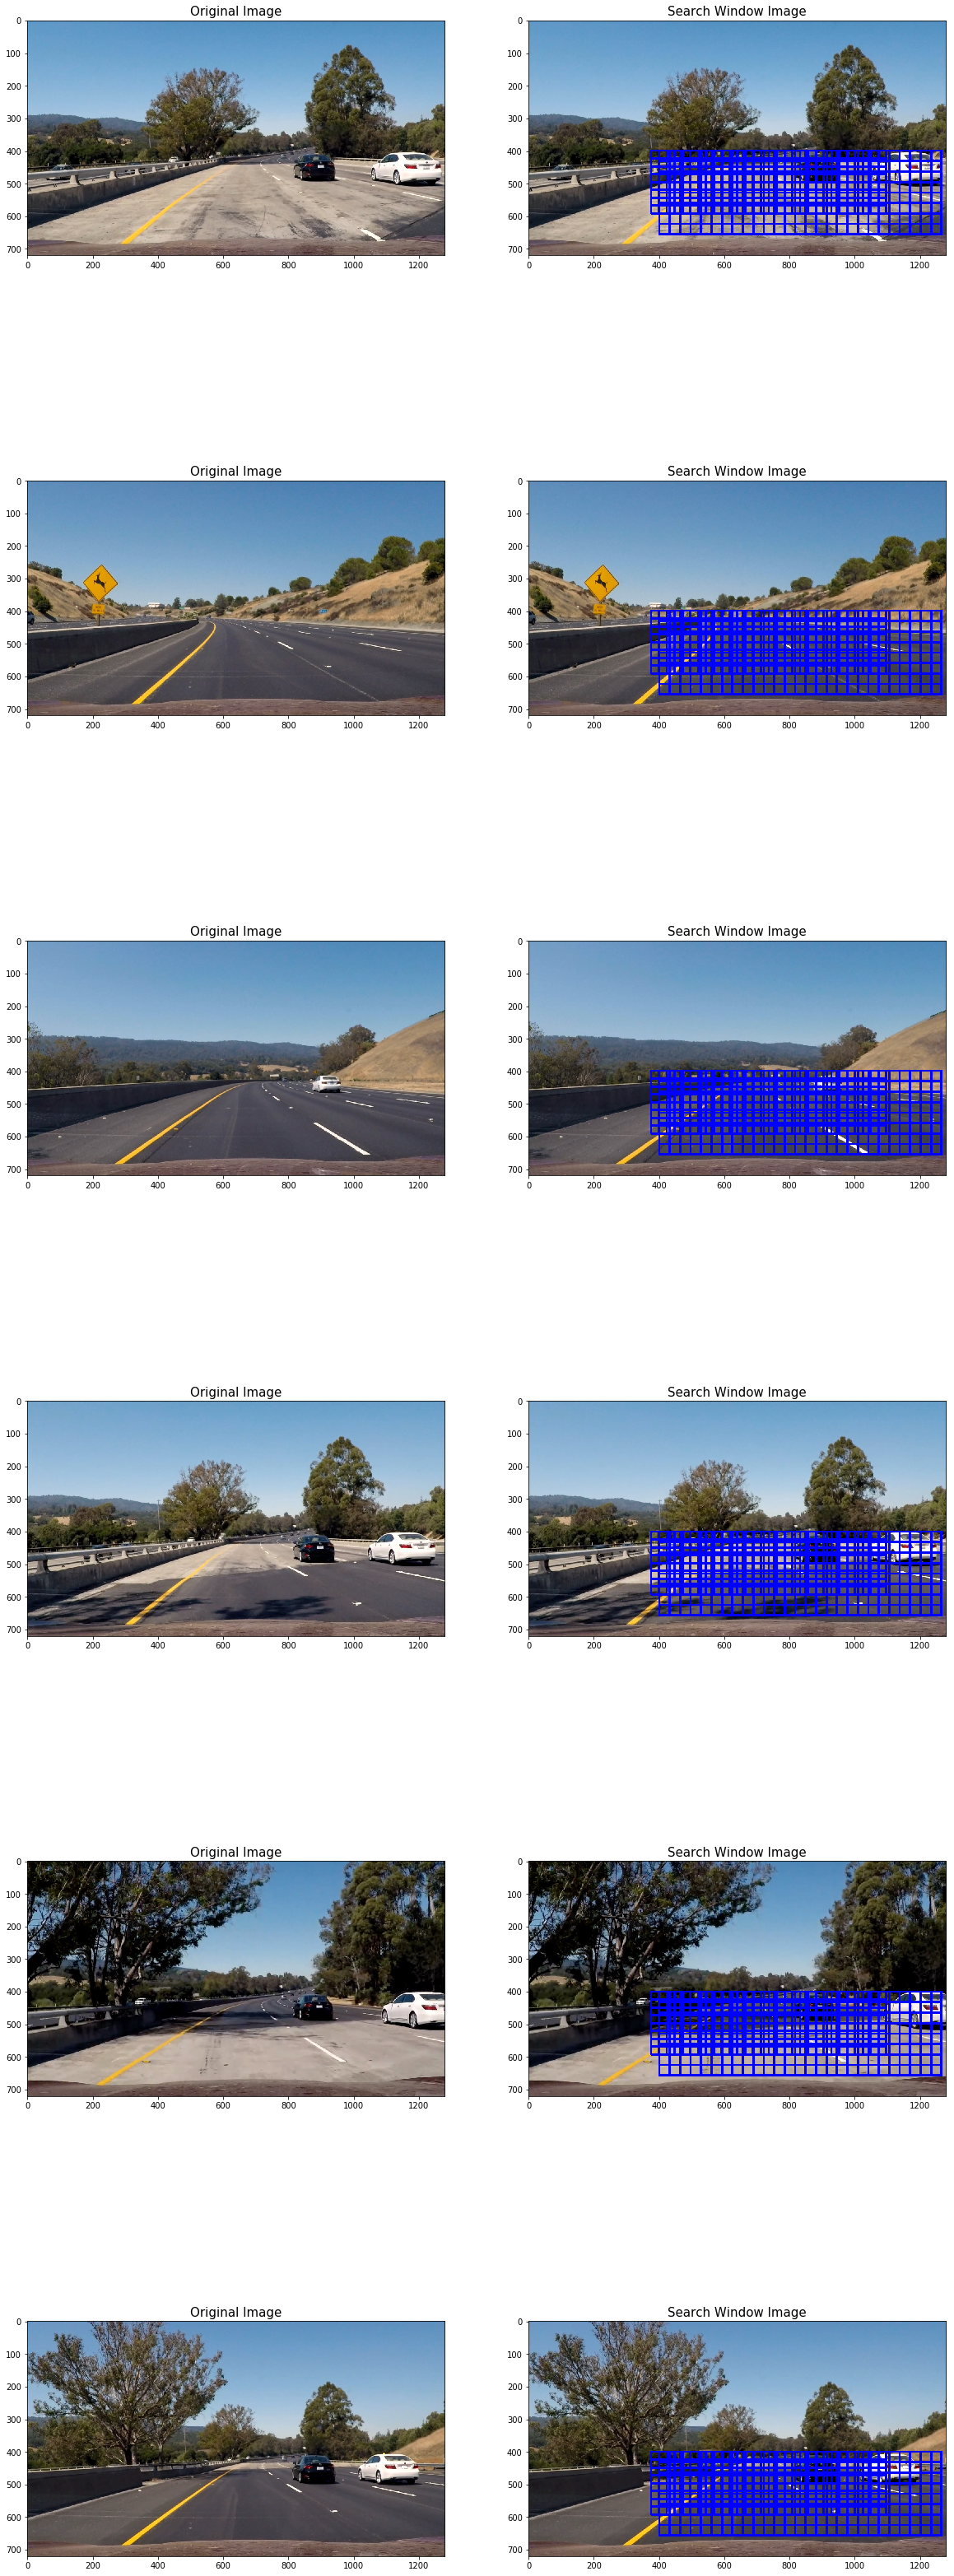

In [10]:
%matplotlib inline
y_start_stop = [400, 660] # Min and max in y to search in slide_window()

# Read all the  Test image paths
image_paths = glob.glob("./test_images/*.jpg")
cnt =0
f, ax = plt.subplots(len(image_paths), 2,figsize=(20,60))

for img_path in image_paths:
    image = mpimg.imread(img_path)
    draw_image = np.copy(image)
    windows = slide_window(draw_image, x_start_stop=[375, 1100], y_start_stop= [400,600], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))

    for window in windows:
        cv2.rectangle(draw_image,(window[0][0],window[0][1]), (window[1][0],window[1][1]),(0,0,255),6)

    windows = slide_window(draw_image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))

    for window in windows:
        cv2.rectangle(draw_image,(window[0][0],window[0][1]), (window[1][0],window[1][1]),(0,0,255),6)     
    # Show original and undistored images.
    ax[cnt,0].imshow(image)
    ax[cnt,0].set_title('Original Image', fontsize=15)
    ax[cnt,1].imshow(draw_image)
    ax[cnt,1].set_title('Search Window Image', fontsize=15)
    cnt+=1
    
# Save the full figure...
f.savefig("./output_images/search_window_images.jpg")

In [11]:
y_start_stop = [400, 660] # Min and max in y to search in slide_window()

def process_image(image):
    # This function implements the pipeline for image processing
    # Given image is searched 2 times with scaling 96x96 and 128x128 respectively
    # Two searches are done sequentially.
    # After every search a heatmap is developed by highlighting windows with cars in red rest all image is blackend
    # In the areas where boxes overlap intensity of the red pixels is increased to increase the final box size.
    # Boundaries of the red blob are identified and boxes are drawn on the final image.
    # This function generates 3 outputs , draw_img is final output , window_img and heatmap_img are 
    # intermediate outputs
    draw_image = np.copy(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    ########### First Search ############
    windows = slide_window(image, x_start_stop=[400, 1100], y_start_stop= [375,600], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    # Draw the windows
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   
    
    ########### Second Search ############
    windows = slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    # Draw the windows
    window_img = draw_boxes(window_img, hot_windows, color=(0, 0, 255), thick=6)   
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(cv2.cvtColor(image,cv2.COLOR_BGR2RGB)), labels)
    
    # Convert 1 Channel Heatmap to 3 Channel Heat Map
    heatmap_img = np.zeros_like(image).astype(np.float)
    heatmap_img[:,:,0] = heatmap
    return draw_img ,window_img, heatmap_img
    

C:\Conda\envs\my_conda\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


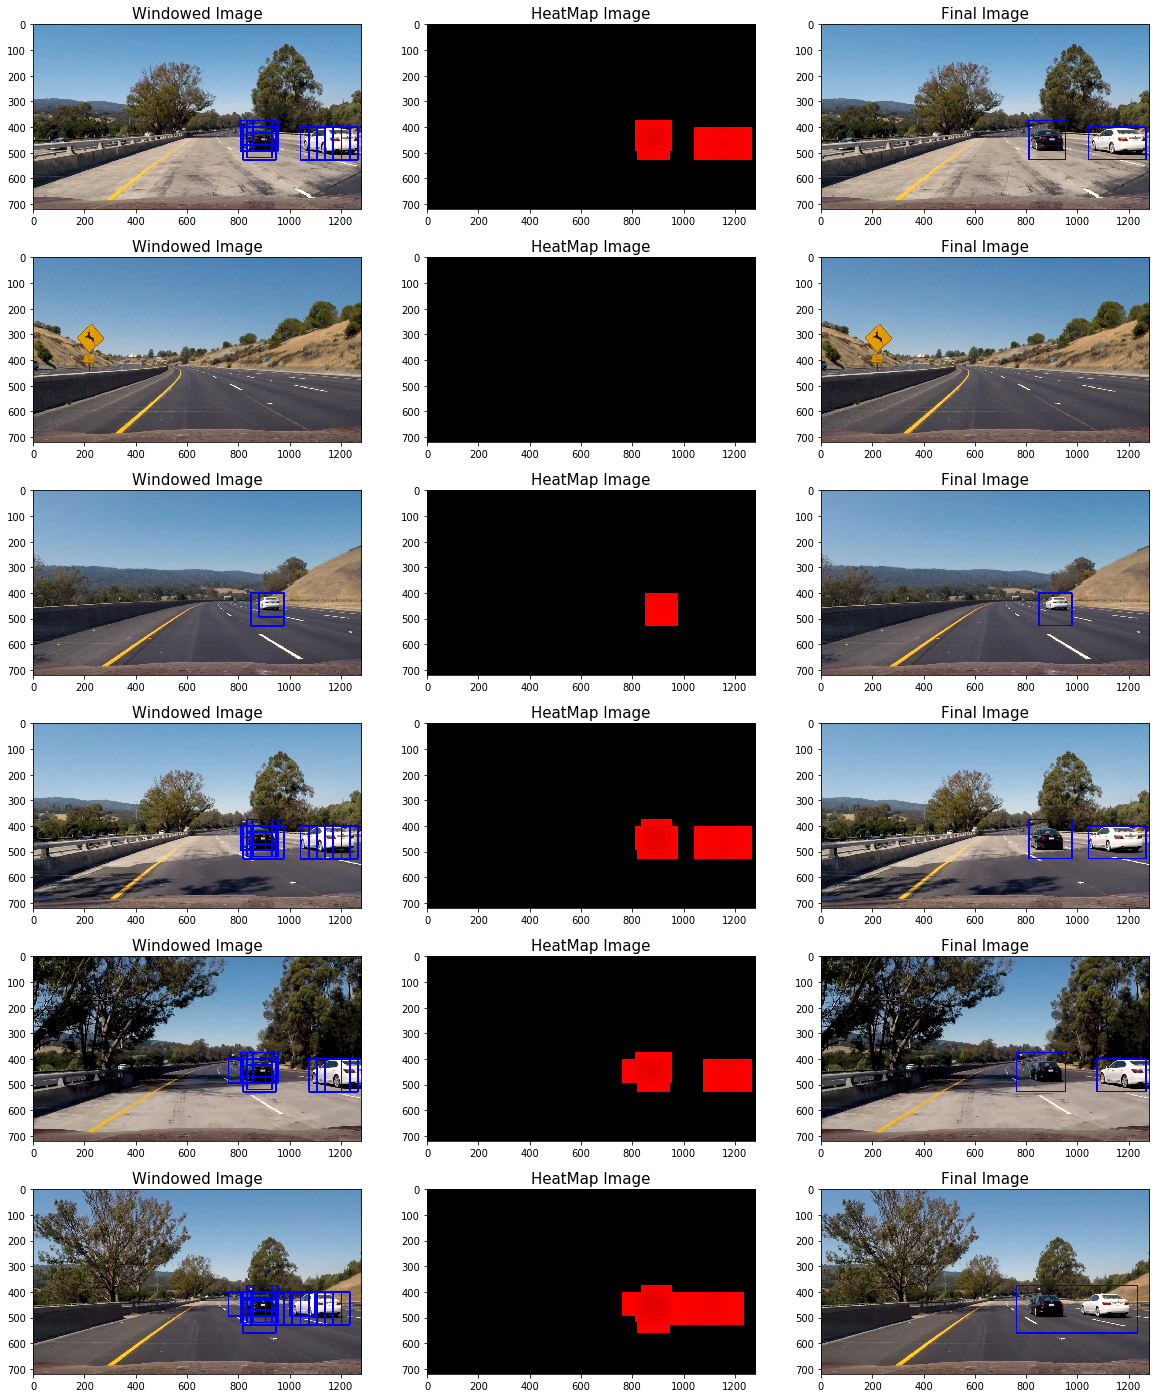

In [12]:
%matplotlib inline
 
# Read all the  Test image paths
image_paths = glob.glob("./test_images/*.jpg")
cnt =0
f, ax = plt.subplots(len(image_paths), 3,figsize=(20,25))

for img_path in image_paths:
    image = cv2.imread(img_path)
    final_img , window_img, heat_map = process_image(image)
         
    # Show original and undistored images.
    ax[cnt,0].imshow(window_img)
    ax[cnt,0].set_title('Windowed Image', fontsize=15)
    ax[cnt,1].imshow(heat_map)
    ax[cnt,1].set_title('HeatMap Image', fontsize=15)
    ax[cnt,2].imshow(final_img)
    ax[cnt,2].set_title('Final Image', fontsize=15)
    cnt+=1

# Save the full figure...
f.savefig("./output_images/heat_map_bounding_box.jpg")

In [13]:
y_start_stop = [400, 660] # Min and max in y to search in slide_window()
heatmaps_queue = collections.deque(maxlen=15)

def process_video(image):
    # This function is simlar to process_image and implements the pipeline for video processing
    # Given image is searched 2 times with scaling 96x96 and 128x128 respectively
    # Two searches are done sequentially.
    # After every search a heatmap is developed by highlighting windows with cars in red rest all image is blackend
    # In the areas where boxes overlap intensity of the red pixels is increased to increase the final box size.
    # To reduce the wobling a queue is formed out of last 15 frames and added , thresholding is applied over the sum.
    # Boundaries of the red blob are identified and boxes are drawn on the final image.
    # This function generates 1 outputs draw_img is final output
    
    global heatmaps_queue
    
    draw_image = np.copy(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    windows = slide_window(image, x_start_stop=[400, 1100], y_start_stop= [375,600], 
                    xy_window=(96, 96), xy_overlap=(0.75, 0.75))
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    windows = slide_window(image, x_start_stop=[400, None], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.75, 0.75))
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)
    
    heatmaps_queue.append(heat)
    heatmap_sum = sum(heatmaps_queue)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heatmap_sum,10)
    #heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(cv2.cvtColor(image,cv2.COLOR_BGR2RGB)), labels)
    
    return cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB)

In [15]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from moviepy.editor import * 

heatmaps_queue.clear()
cap = VideoFileClip('project_video.mp4')
modified_clip = cap.fl_image( process_video )
%time modified_clip.write_videofile("output_videos/project_video.mp4")

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing audio in project_videoTEMP_MPY_wvf_snd.mp3


100%|████████████████████████████████████████████████████████████████████████████| 1112/1112 [00:00<00:00, 2185.35it/s]


[MoviePy] Done.
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [26:11<00:01,  1.22s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 26min 13s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos/project_video.mp4"))